# This Notebook includes code to generate:
1) STS Plots
2) Comparing Classification Results of Encoders Plots
3) Improvement Plots

In [1]:
# Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [44]:
# Fix fonts
font_files = font_manager.findSystemFonts(fontpaths=['font/'])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Verify the font is recognized by Matplotlib
font_name = "Times New Roman"
if font_name in font_manager.get_font_names():
    print(f"'{font_name}' font successfully added.")
    # Set default font to Times New Roman
    matplotlib.rc('font', family=font_name)
else:
    print(f"'{font_name}' font not found. Please check the font installation.")

'Times New Roman' font successfully added.


# STS

### Spearman of different whitenings

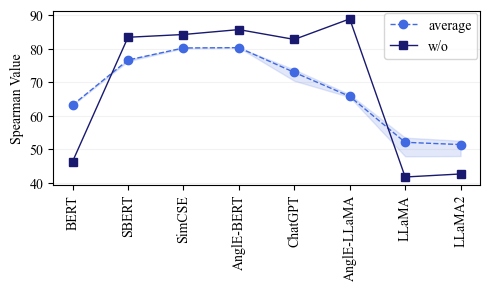

In [45]:
def clean_data(data):
    mlp_acc_results = data.drop(['pearson_value'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'w/o')
    encoder_order = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'ChatGPT', 'angle-llama', 'llama-7B', 'llama2-7B']
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('text-embedding-3-small', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('all-mpnet-base-v2', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-llama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-bert', 'AnglE-BERT')
    return mlp_acc_results

data = pd.read_json('https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results/sts_eval/eval_results.json')
sts_results = clean_data(data)

df = sts_results[sts_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
avg_df = df.groupby('encoder')['spearman_value'].mean().reset_index()
max_df = np.array(df.groupby('encoder')['spearman_value'].max())
min_df = np.array(df.groupby('encoder')['spearman_value'].min())
avg_df['whitening'] = 'average'
avg_df['min_spearman_value'] = min_df
avg_df['max_spearman_value'] = max_df
avg_df['whitening'] = 'average'
wo_df = sts_results[sts_results['whitening'].isin(['w/o'])]
sts_results = pd.concat([avg_df, wo_df], axis=0)

# Draw line plot
plt.figure(figsize=(5, 3))
colors = ['royalblue', 'midnightblue']
i = 0
for whitening, group in sts_results.groupby('whitening'):
    linestyle = '-' if whitening == 'w/o' else 'dashed'
    marker = 's' if whitening == 'w/o' else 'o'
    plt.plot(group['encoder'], group['spearman_value'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[i], linewidth=1)
    plt.fill_between(group['encoder'], group['min_spearman_value'], group['max_spearman_value'], color=colors[c], alpha=.15)

    i = i + 1
i = 0

plt.xticks(rotation=90)
plt.ylabel('Spearman Value')
plt.grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
# plt.xticks(ha='right')
plt.legend(bbox_to_anchor=(1.01, 1.03), loc='upper right' )
plt.tight_layout()
plt.savefig('sts.pdf', format='pdf')
plt.show()

### distribution of cosine similarity plots

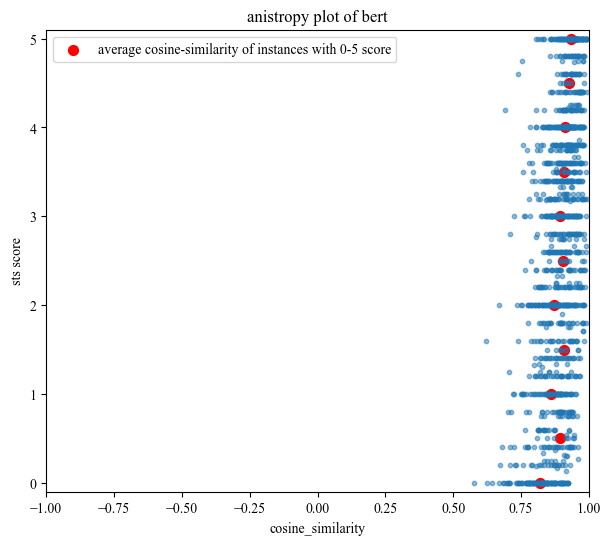

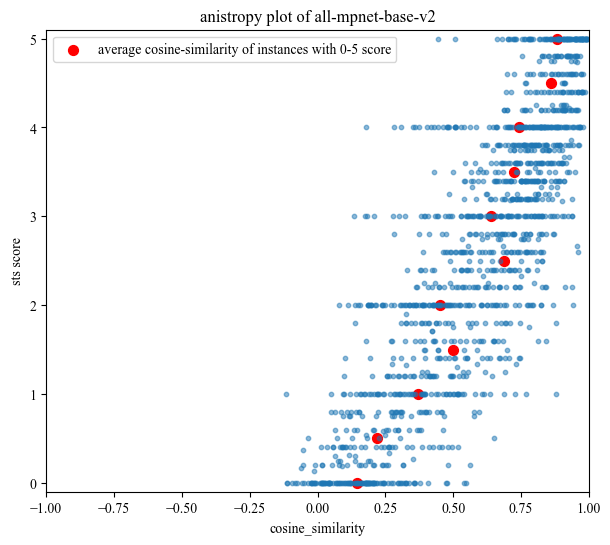

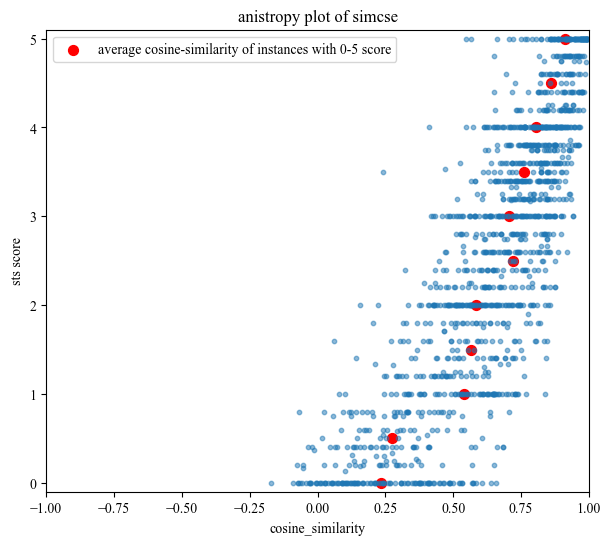

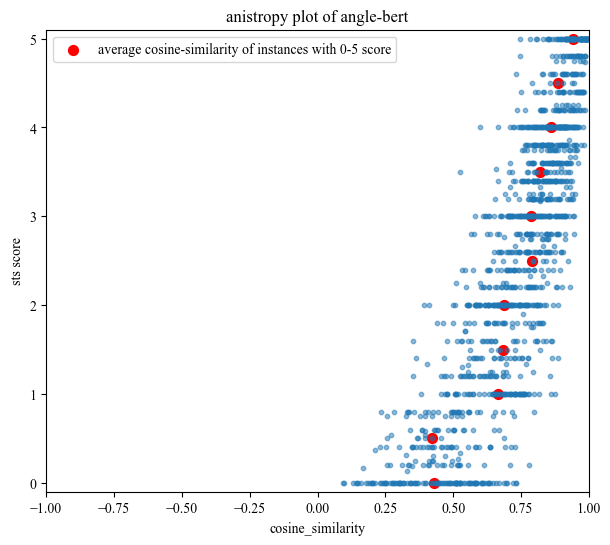

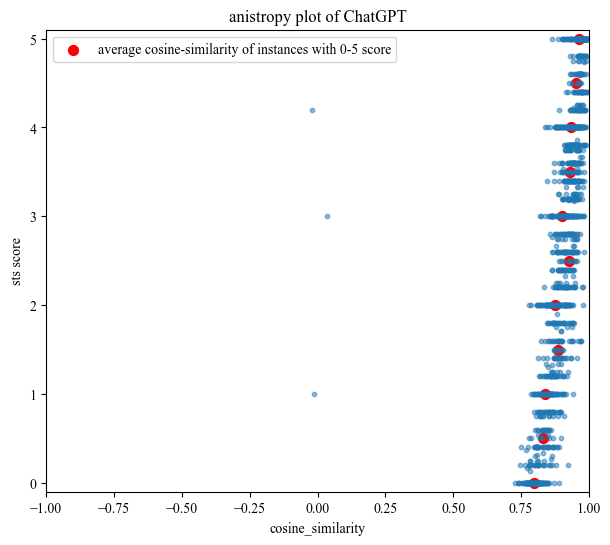

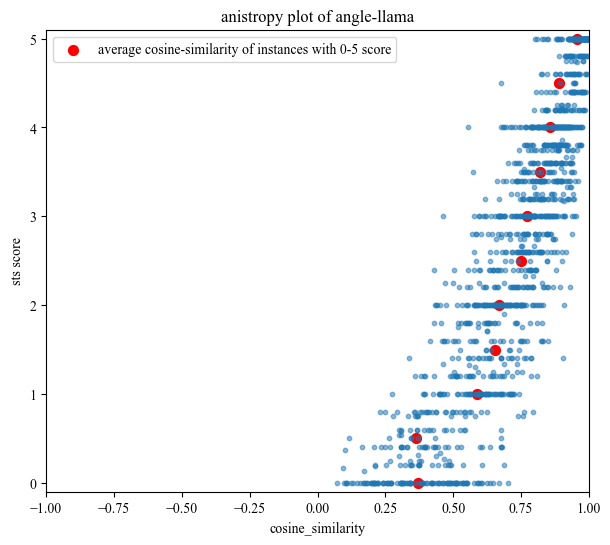

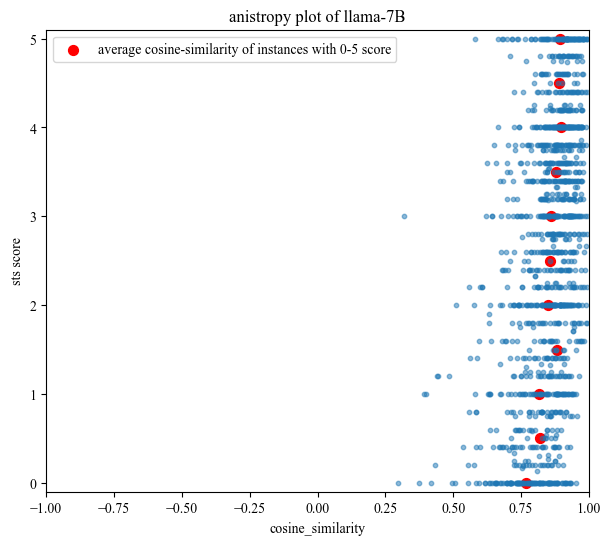

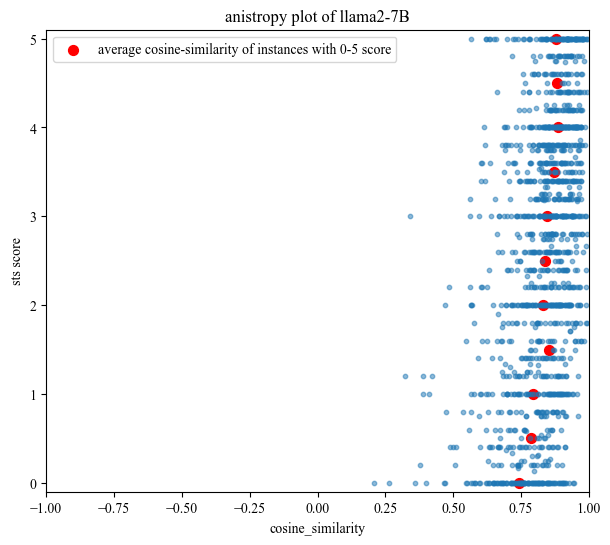

In [55]:
base_path = 'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results'
encoders = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'ChatGPT', 'angle-llama', 'llama-7B', 'llama2-7B']
for encoder in encoders:
    df_scores = pd.read_csv(f'{base_path}/sts_eval/cosim/{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    # print(df_scores)
    plt.figure(figsize=(7, 6))

    for i in range (0, 12):
        current_value = i * 0.5
        filtered_df = df_scores.loc[df_scores['score'] == current_value]
        average_value = filtered_df['cos_sim'].mean()
        plt.scatter(average_value, current_value, s=50, color='red')

    plt.title(f'anistropy plot of {encoder}')
    plt.scatter(df_scores['cos_sim'], df_scores['score'], s=10, label='sts instances', alpha=0.5)
    plt.ylim(-0.1,5.1)
    plt.xlim(-1,1)
    plt.xlabel('cosine_similarity')
    plt.ylabel('sts score')
    plt.legend(['average cosine-similarity of instances with 0-5 score'])

    plt.savefig(f'results/sts_eval/anistropy_plots/{encoder}.png')
    plt.show()

### denisity of cosine similarity plots

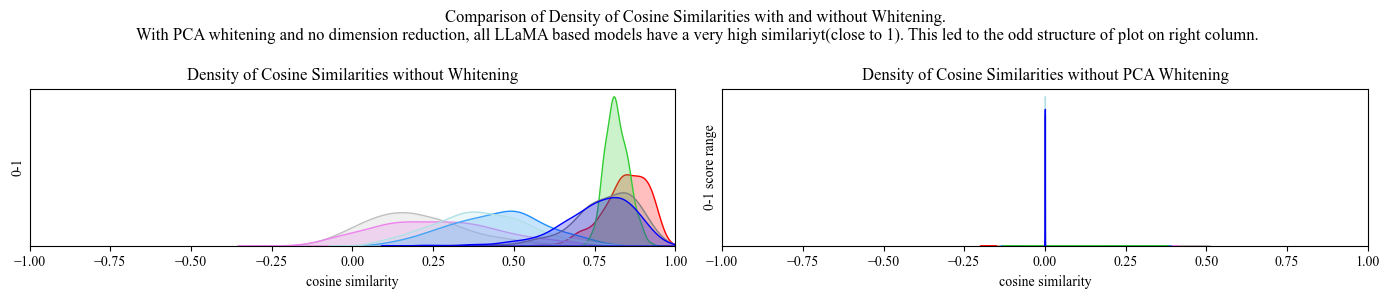

In [56]:
base_path = 'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results'
encoders = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'ChatGPT', 'angle-llama', 'llama-7B', 'llama2-7B']
fig, axs = plt.subplots(1, 2, figsize=(14, 3))

colors = ['red', 'silver', 'violet', 'dodgerblue', 'limegreen','powderblue','grey','blue']
for i, encoder in enumerate(encoders):
    df_scores = pd.read_csv(f'{base_path}/sts_eval/cosim/{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores = df_scores[(df_scores['score'] < 1) & (df_scores['score'] >= 0)]
    sns.kdeplot(data=df_scores['cos_sim'], ax=axs[0], fill=True, label=encoder, color=colors[i])
    axs[0].set_title('Density of Cosine Similarities without Whitening')
    axs[0].set_ylabel('0-1')
    axs[0].set_xlim(-1, 1)
    axs[0].set_yticks([])
    axs[0].set_xlabel('cosine similarity')
    axs[0].grid(False)


for i, encoder in enumerate(encoders):
    df_scores = pd.read_csv(f'{base_path}/sts_eval/cosim/whpca-{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores = df_scores[(df_scores['score'] < 1) & (df_scores['score'] >= 0)]
    sns.kdeplot(data=df_scores['cos_sim'], ax=axs[1], fill=True, label=encoder, color=colors[i])
    axs[1].set_title('Density of Cosine Similarities without PCA Whitening')
    axs[1].set_ylabel('0-1 score range')
    axs[1].set_xlim(-1, 1)
    axs[1].set_xlabel('cosine similarity')

    axs[1].set_yticks([])
    axs[1].grid(False)

fig.suptitle('Comparison of Density of Cosine Similarities with and without Whitening.\n With PCA whitening and no dimension reduction, all LLaMA based models have a very high similariyt(close to 1). This led to the odd structure of plot on right column.')
plt.tight_layout()
plt.savefig(f'results/sts_eval/cosine_plots/without_whitening.png')
plt.show()

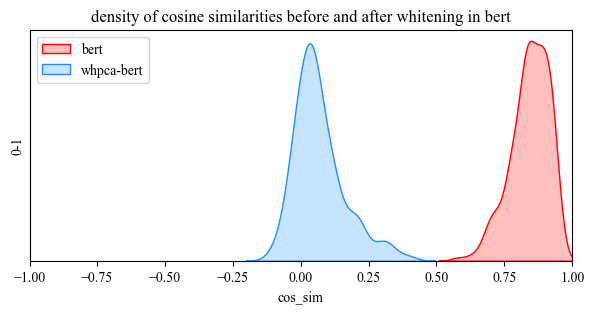

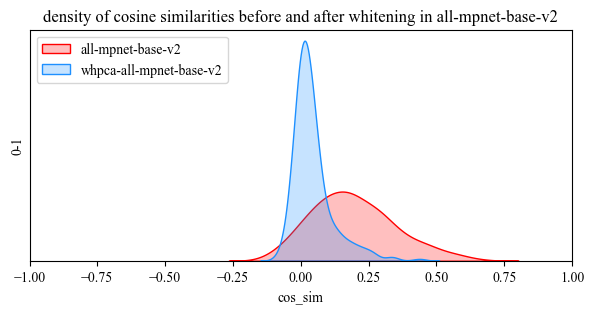

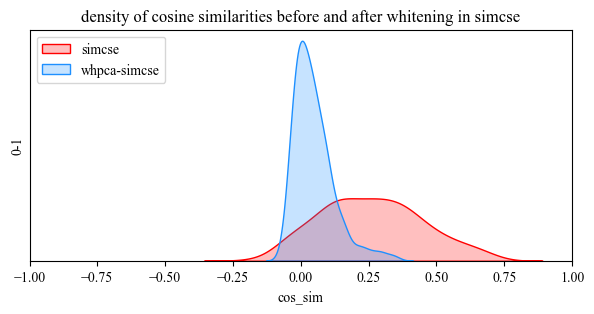

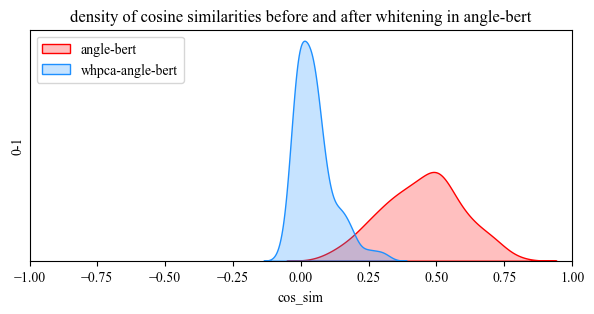

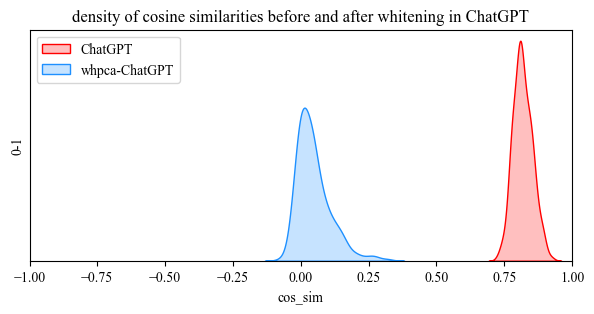

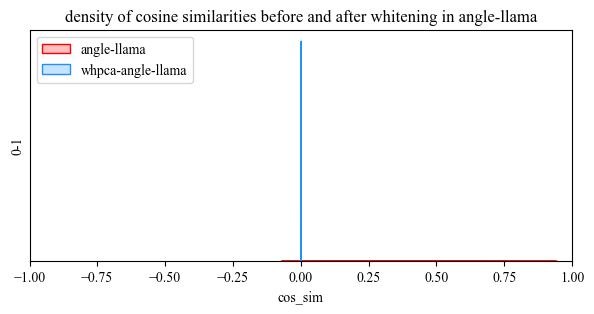

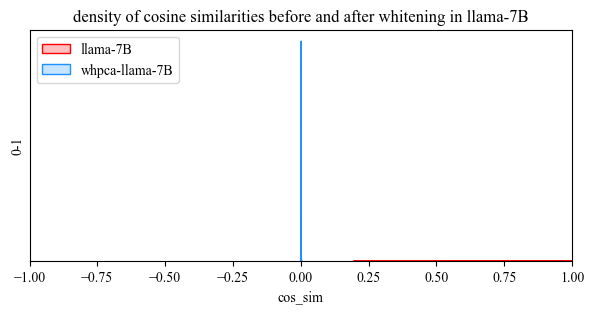

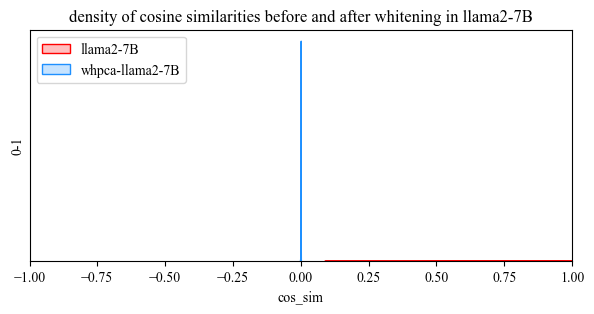

In [57]:
base_path = 'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results'
colors = ['red', 'dodgerblue', 'silver', 'violet', 'limegreen']

for encoder in encoders:
    plt.figure(figsize=(7, 3))
    plt.title(f'density of cosine similarities before and after whitening in {encoder}')
    df_scores_now = pd.read_csv(f'{base_path}/sts_eval/cosim/{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores_now = df_scores_now[(df_scores_now['score'] < 1) & (df_scores_now['score'] >= 0)]
    sns.kdeplot(data=df_scores_now['cos_sim'], fill=True, label=encoder, color=colors[0])

    df_scores_w = pd.read_csv(f'{base_path}/sts_eval/cosim/whpca-{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores_w = df_scores_w[(df_scores_w['score'] < 1) & (df_scores_w['score'] >= 0)]
    sns.kdeplot(data=df_scores_w['cos_sim'], fill=True, label='whpca-'+encoder, color=colors[1])

    plt.ylabel('0-1')
    plt.xlim(-1,1)
    plt.yticks([])
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.savefig(f'results/sts_eval/cosine_plots/{encoder}.png')
    plt.show()

# Classification Plots

### accuracy of different whitenings

/tmp/ipykernel_324505/1694293211.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_324505/1694293211.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_324505/1694293211.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)


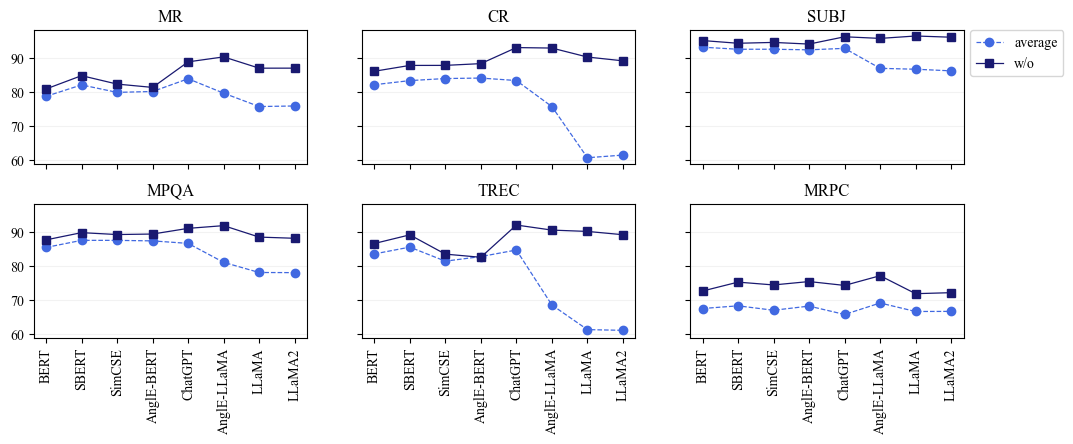

In [71]:
def clean_data(data):
    mlp_acc_results = data.drop(['classfier', 'IScore', 'accuracy_list', 'kfold'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'w/o')
    encoder_order = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'text-embedding-3-small', 'angle-llama', 'llama-7B', 'llama2-7B']
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('text-embedding-3-small', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('all-mpnet-base-v2', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-llama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-bert', 'AnglE-BERT')
    return mlp_acc_results

colors = ['midnightblue', 'royalblue','midnightblue','royalblue','midnightblue','deepskyblue','powderblue']
datasets = ["mr", "cr", "subj", "mpqa", "trec", "mrpc"] # last mr should replaced by MRPC
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 4))
fig.subplots_adjust(hspace=0.30)
# fig.subplots_adjust(wspace=0.05)

for z, dataset in enumerate(datasets):
    data = pd.read_json(f'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results/{dataset}_eval/mlp_eval_results.json')
    mlp_acc_results = clean_data(data)

    avg_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
    avg_df = avg_df.groupby('encoder')['accuracy'].mean().reset_index()
    avg_df['whitening'] = 'average'
    wo_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['w/o'])]
    mlp_acc_results = pd.concat([avg_df, wo_df], axis=0)

    c = 0
    for whitening, group in mlp_acc_results.groupby('whitening'):
        c = c + 1
        linestyle = '-' if whitening == 'w/o' else 'dashed'
        marker = 's' if whitening == 'w/o' else 'o'
        i, j = divmod(z, 3)
        axs[i, j].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
        # axs[z].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
    c = 0
    axs[i,j].set_title(dataset.upper())
    # axs[z].set_title(dataset.upper())

    axs[i,j].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
    # axs[z].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    if(i==1):
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)

plt.legend(bbox_to_anchor=(1.39, 2.35), loc='upper right')
plt.savefig('cls.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Improvement plots

#### improvement plots - one dataset

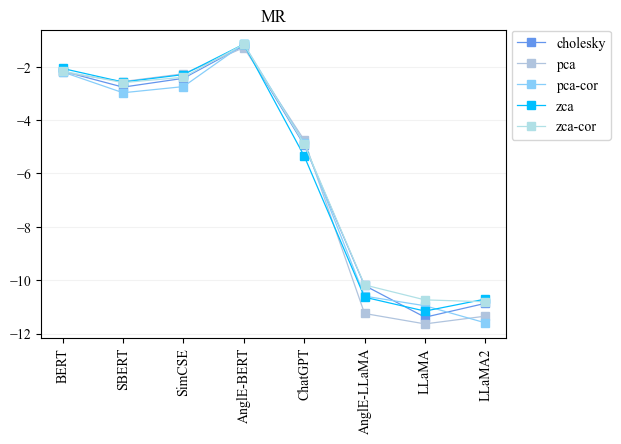

In [105]:
colors = ['cornflowerblue', 'lightsteelblue','lightskyblue','deepskyblue','powderblue','red','green']
dataset = 'mr'
data = pd.read_json(f'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results/{dataset}_eval/mlp_eval_results.json')
mlp_acc_results = clean_data(data)
plt.figure(figsize=(6, 4))

wo = mlp_acc_results[mlp_acc_results['whitening'] == 'w/o']
wo = np.array(wo['accuracy'].tolist())
whitening_methods = ["cholesky", "pca", "pca-cor", "zca", "zca-cor"]
c = 0
for method in whitening_methods:
    # linestyle = '-' if method == 'w/o' else 'dashed'
    # marker = 's' if method == 'w/o' else 'o'
    method_data = mlp_acc_results[mlp_acc_results['whitening'] == method]
    method_data = np.array(method_data['accuracy'].tolist())
    result = [a - b for a, b in zip(method_data, wo)]
    plt.plot(mlp_acc_results['encoder'].unique(), result, label=f'{method}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
    c = c + 1
c = 0
plt.title(dataset.upper())
plt.grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.24, 1.02), loc='upper right')
plt.savefig('imp.pdf', format='pdf', bbox_inches='tight')
plt.show()

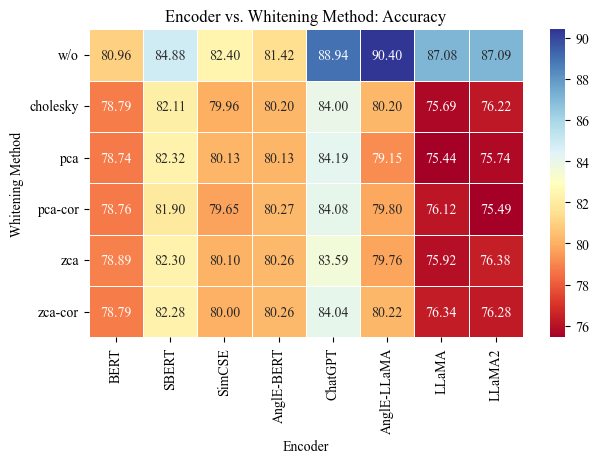

In [100]:
mlp_acc_results['whitening'] = pd.Categorical(mlp_acc_results['whitening'], categories=['w/o', 'cholesky', 'pca', 'pca-cor', 'zca', 'zca-cor'], ordered=True)
heatmap_data = pd.pivot_table(mlp_acc_results, values='accuracy', index='whitening', columns='encoder')

plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap="RdYlBu")

plt.title('Encoder vs. Whitening Method: Accuracy')
plt.xlabel('Encoder')
plt.ylabel('Whitening Method')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

#### improvement plots - subplots

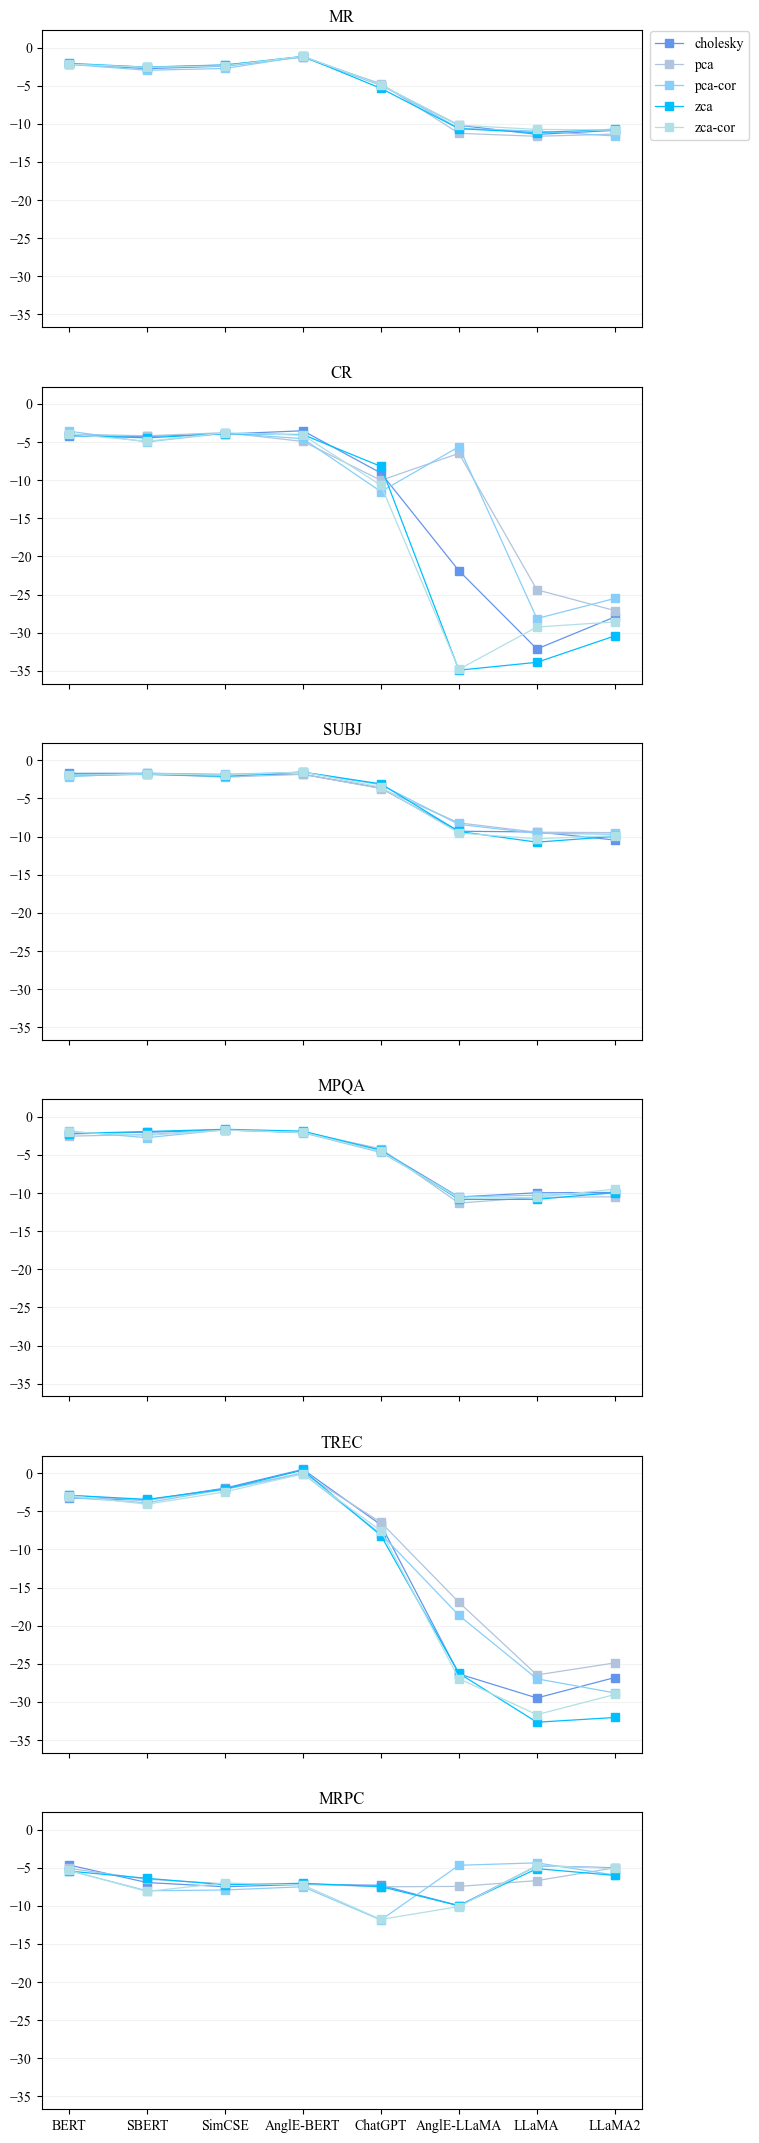

In [74]:
colors = ['cornflowerblue', 'lightsteelblue','lightskyblue','deepskyblue','powderblue','red','green']

datasets = ["mr", "cr", "subj", "mpqa", "trec", "mrpc"] # last mr should replaced by MRPC

fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(7.75, 27))
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.05)

for z, dataset in enumerate(datasets):

    data = pd.read_json(f'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results/{dataset}_eval/mlp_eval_results.json')
    mlp_acc_results = clean_data(data)

    wo = mlp_acc_results[mlp_acc_results['whitening'] == 'w/o']
    wo = np.array(wo['accuracy'].tolist())
    whitening_methods = ["cholesky", "pca", "pca-cor", "zca", "zca-cor"]
    c = 0
    for method in whitening_methods:
        # linestyle = '-' if method == 'w/o' else 'dashed'
        # marker = 's' if method == 'w/o' else 'o'
        method_data = mlp_acc_results[mlp_acc_results['whitening'] == method]
        method_data = np.array(method_data['accuracy'].tolist())
        result = [a - b for a, b in zip(method_data, wo)]
        axs[z].plot(mlp_acc_results['encoder'].unique(), result, label=f'{method}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
        c = c + 1
    c = 0
    axs[z].set_title(dataset.upper())
    axs[z].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
plt.legend(bbox_to_anchor=(1.19, 7.02), loc='upper right')
# plt.savefig(path, format='pdf', bbox_inches='tight')
plt.show()

### Accuracy + Improvement

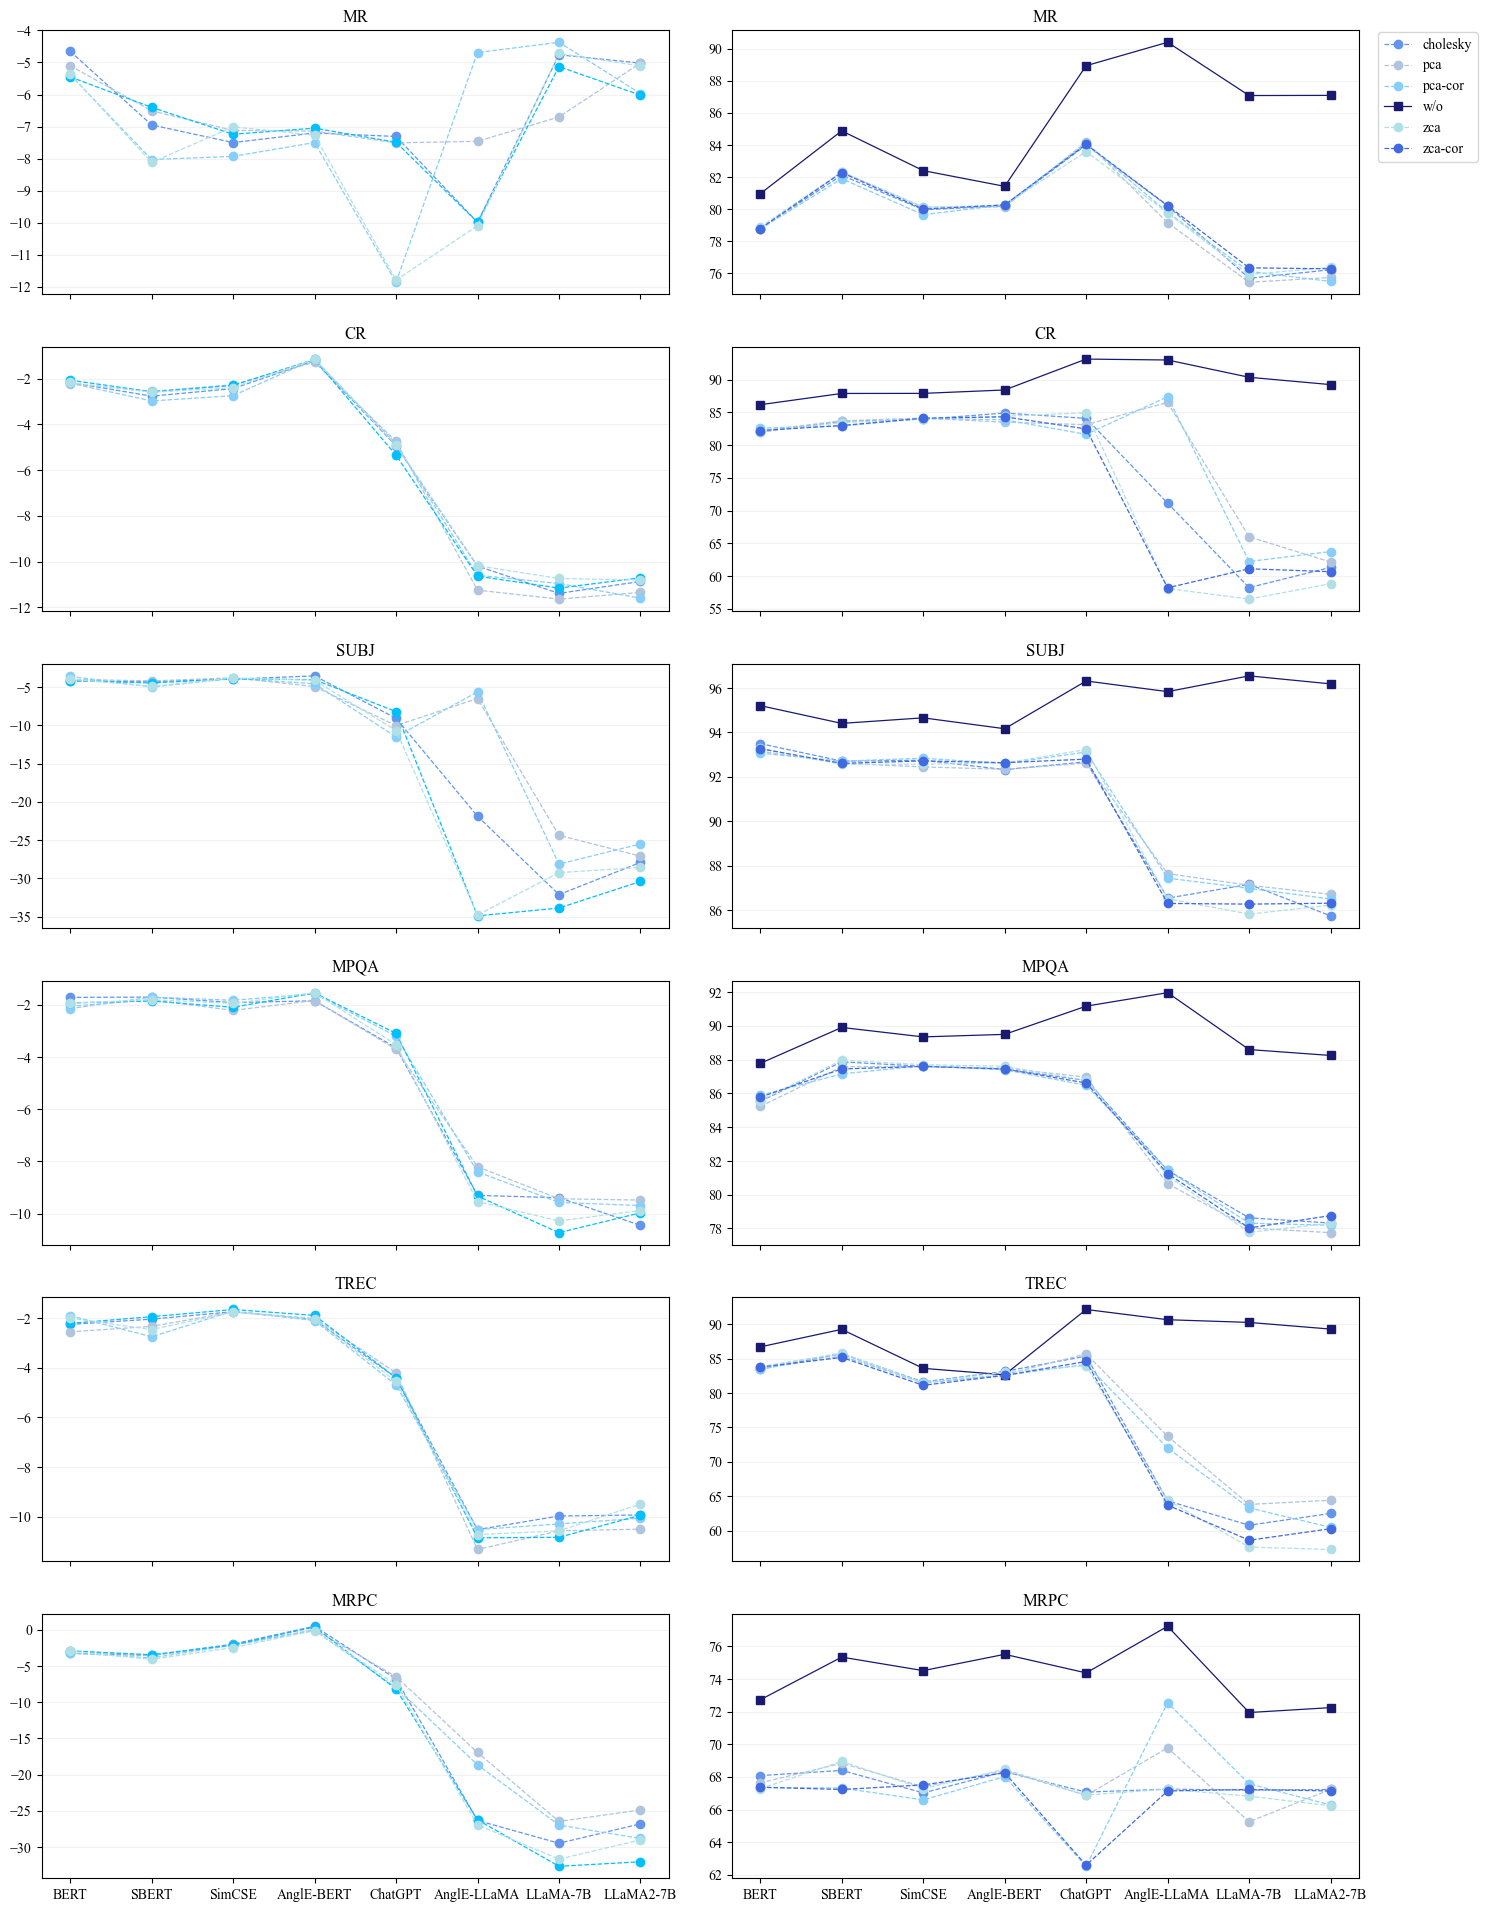

In [ ]:
colors = ['midnightblue','cornflowerblue','lightsteelblue','lightskyblue','deepskyblue','powderblue','royalblue']
datasets = ["mr", "cr", "subj", "mpqa", "trec", "mrpc"] # last mr should replaced by MRPC

fig, axs = plt.subplots(6, 2, sharex=True, figsize=(17, 24))
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.10)

for z, dataset in enumerate(datasets):
    # second column (improvement plots)
    wo = mlp_acc_results[mlp_acc_results['whitening'] == 'w/o']
    wo = np.array(wo['accuracy'].tolist())
    whitening_methods = ["cholesky", "pca", "pca-cor", "zca", "zca-cor"]
    c = 1
    for method in whitening_methods:
        method_data = mlp_acc_results[mlp_acc_results['whitening'] == method]
        method_data = np.array(method_data['accuracy'].tolist())
        result = [a - b for a, b in zip(method_data, wo)]
        axs[z, 0].plot(mlp_acc_results['encoder'].unique(), result, label=f'{method}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
        c = c + 1
    c = 1
    axs[z, 0].set_title(dataset.upper())
    axs[z, 0].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    data = pd.read_json(f'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results/{dataset}_eval/mlp_eval_results.json')
    mlp_acc_results = clean_data(data)

    c = 1
    for whitening, group in mlp_acc_results.groupby('whitening'):
        linestyle = '-' if whitening == 'w/o' else 'dashed'
        marker = 's' if whitening == 'w/o' else 'o'
        color = 'midnightblue' if whitening == 'w/o' else colors[c]
        axs[z, 1].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=color, linewidth=0.9)
        c = c + 1
    c = 1

    axs[z, 1].set_title(dataset.upper())
    axs[z, 1].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)


plt.legend(bbox_to_anchor=(1.20, 7.02), loc='upper right')
plt.savefig('hybrid-plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_2348555/722315063.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_2348555/722315063.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_2348555/722315063.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_2348555/722315063.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)


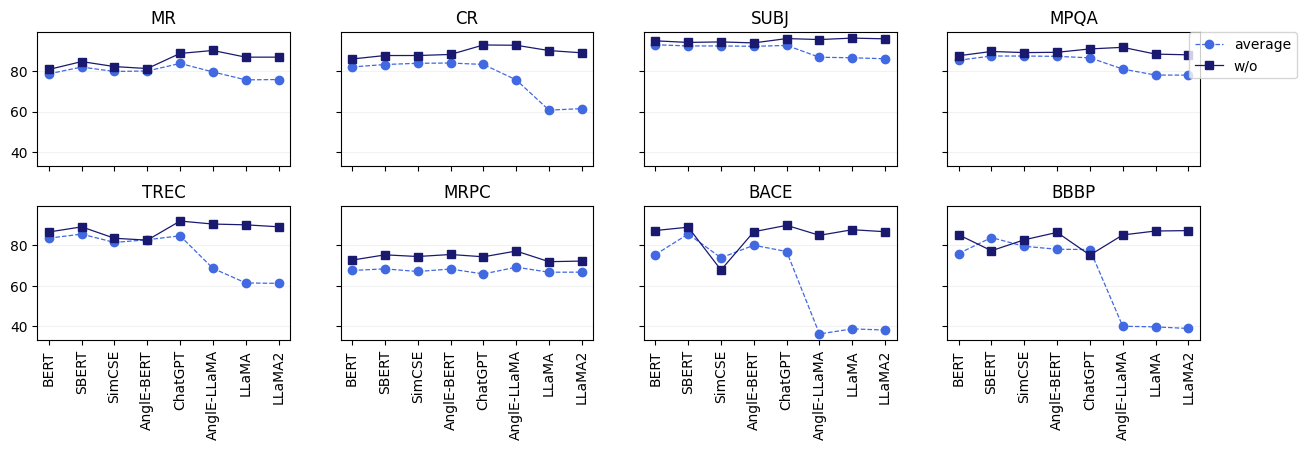

In [13]:
def clean_data_sh(data):
    mlp_acc_results = data.drop(['classfier', 'IScore', 'accuracy_list', 'kfold'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'w/o')
    encoder_order = [
            "bert-base-uncased",
            "sbert",
            "simcse",
            "angleBert","GPT", "angleLlama",
            "llama-7B", "llama2-7B"
        ]
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('GPT', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert-base-uncased', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('sbert', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angleLlama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angleBert', 'AnglE-BERT')
    mlp_acc_results['dataset'] = mlp_acc_results['dataset'].replace('bace_classification', 'BACE C')
    mlp_acc_results['dataset'] = mlp_acc_results['dataset'].replace('bbbp', 'BBBP')
    mlp_acc_results['dataset'] = mlp_acc_results['dataset'].replace('clintox', 'ClinTox')

    return mlp_acc_results

def clean_data(data):
    mlp_acc_results = data.drop(['classfier', 'IScore', 'accuracy_list', 'kfold'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'w/o')
    encoder_order = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'text-embedding-3-small', 'angle-llama', 'llama-7B', 'llama2-7B']
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('text-embedding-3-small', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('all-mpnet-base-v2', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-llama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-bert', 'AnglE-BERT')
    return mlp_acc_results

# uq = mlp_acc_results['encoder'].unique()
# print(uq)
# avg_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
# avg_df = avg_df.groupby('encoder')['accuracy'].mean().reset_index()
# avg_df['whitening'] = 'average'
# wo_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['w/o'])]
# mlp_acc_results = pd.concat([avg_df, wo_df], axis=0)

colors = ['midnightblue', 'royalblue','midnightblue','royalblue','midnightblue','deepskyblue','powderblue']
datasets_sh = ['bace', 'bbbp'] 
datasets = ["mr", "cr", "subj", "mpqa", "trec", "mrpc"] + datasets_sh # last mr should replaced by MRPC

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15, 4))
fig.subplots_adjust(hspace=0.30)
# fig.subplots_adjust(wspace=0.05)

for z, dataset in enumerate(datasets):
    data = pd.read_json(f'results/{dataset}_eval/mlp_eval_results.json')
    if dataset in datasets_sh:
        mlp_acc_results = clean_data_sh(data)
    else:
        mlp_acc_results = clean_data(data)

    avg_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
    avg_df = avg_df.groupby('encoder')['accuracy'].mean().reset_index()
    avg_df['whitening'] = 'average'
    wo_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['w/o'])]
    mlp_acc_results = pd.concat([avg_df, wo_df], axis=0)
    c = 0
    for whitening, group in mlp_acc_results.groupby('whitening'):
        c = c + 1
        linestyle = '-' if whitening == 'w/o' else 'dashed'
        marker = 's' if whitening == 'w/o' else 'o'

        # if(dataset in datasets_sh and whitening != 'w/o'):
        #     color='limegreen'
        # elif(dataset in datasets_sh and whitening == 'w/o'):
        #     color='forestgreen'
        # else:
        #     color = colors[c]

        i, j = divmod(z, 4)
        axs[i, j].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
        # axs[z].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
    c = 0
    axs[i,j].set_title(dataset.upper())
    # axs[z].set_title(dataset.upper())

    axs[i,j].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
    # axs[z].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    if(i==1):
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)

plt.legend(bbox_to_anchor=(1.41, 2.35), loc='upper right')
plt.savefig('cls.pdf', format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_2348555/2227176577.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_2348555/2227176577.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_2348555/2227176577.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
/tmp/ipykernel_2348555/2227176577.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)


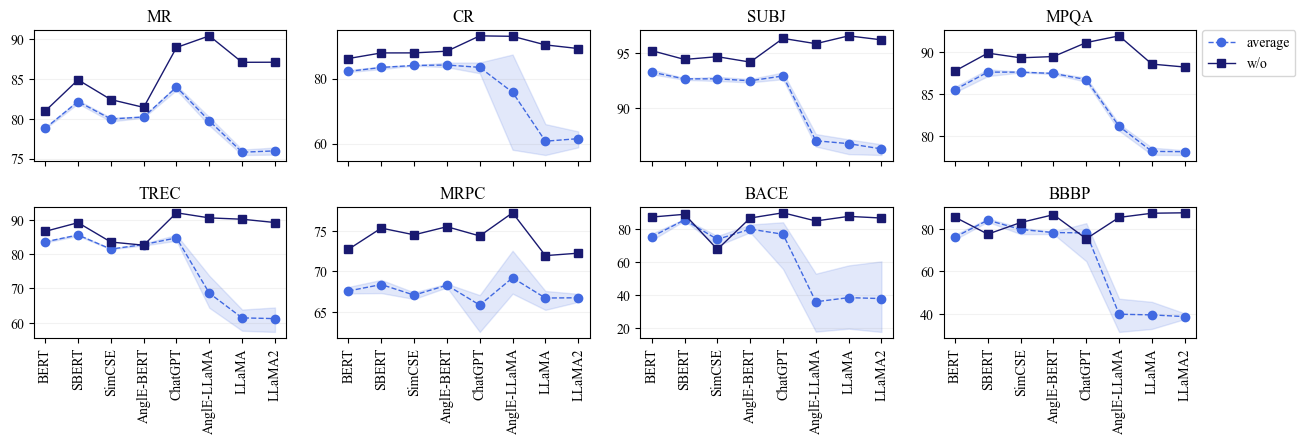

In [52]:
def clean_data_sh(data):
    mlp_acc_results = data.drop(['classfier', 'IScore', 'accuracy_list', 'kfold'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'w/o')
    encoder_order = ["bert-base-uncased", "sbert", "simcse", "angleBert", "GPT", "angleLlama", "llama-7B", "llama2-7B"]
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('GPT', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert-base-uncased', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('sbert', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angleLlama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angleBert', 'AnglE-BERT')
    mlp_acc_results['dataset'] = mlp_acc_results['dataset'].replace('bace_classification', 'bace')
    mlp_acc_results['dataset'] = mlp_acc_results['dataset'].replace('bbbp', 'BBBP')
    mlp_acc_results['dataset'] = mlp_acc_results['dataset'].replace('clintox', 'ClinTox')
    return mlp_acc_results

def clean_data(data):
    mlp_acc_results = data.drop(['classfier', 'IScore', 'accuracy_list', 'kfold'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'w/o')
    encoder_order = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'text-embedding-3-small', 'angle-llama', 'llama-7B', 'llama2-7B']
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('text-embedding-3-small', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('all-mpnet-base-v2', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-llama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-bert', 'AnglE-BERT')
    return mlp_acc_results

colors = ['midnightblue', 'royalblue','midnightblue','royalblue','midnightblue','deepskyblue','powderblue']
datasets_sh = ['bace', 'bbbp'] 
datasets = ["mr", "cr", "subj", "mpqa", "trec", "mrpc"] + datasets_sh # last mr should replaced by MRPC

fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(15, 4))
fig.subplots_adjust(hspace=0.35)
# fig.subplots_adjust(wspace=0.05)

for z, dataset in enumerate(datasets):
    data = pd.read_json(f'results/{dataset}_eval/mlp_eval_results.json')
    if dataset in datasets_sh:
        mlp_acc_results = clean_data_sh(data)
    else:
        mlp_acc_results = clean_data(data)

    df = mlp_acc_results[mlp_acc_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
    avg_df = df.groupby('encoder')['accuracy'].mean().reset_index()
    max_df = np.array(df.groupby('encoder')['accuracy'].max())
    min_df = np.array(df.groupby('encoder')['accuracy'].min())
    avg_df['whitening'] = 'average'
    avg_df['dataset'] = dataset
    avg_df['min_accuracy'] = min_df
    avg_df['max_accuracy'] = max_df
    wo_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['w/o'])]
    mlp_acc_results = pd.concat([avg_df, wo_df], axis=0)
    c = 0
    for whitening, group in mlp_acc_results.groupby('whitening'):
        c = c + 1
        linestyle = '-' if whitening == 'w/o' else 'dashed'
        marker = 's' if whitening == 'w/o' else 'o'

        i, j = divmod(z, 4)
        axs[i, j].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=1)
        axs[i, j].fill_between(group['encoder'], group['min_accuracy'], group['max_accuracy'], color=colors[c], alpha=.15)
        # axs[z].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.9)
    c = 0
    axs[i,j].set_title(dataset.upper())
    # axs[z].set_title(dataset.upper())

    axs[i,j].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
    # axs[z].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    if(i==1):
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)

plt.legend(bbox_to_anchor=(1.42, 2.40), loc='upper right')
plt.savefig('cls.pdf', format='pdf', bbox_inches='tight')